In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import devkit.api as dk
import finkit.api as fk
import Factor.api as factor
import ModelAPI.api as model
import alpha.api as alpha
import pandas as pd
import numpy as np
import os
import gc
from sklearn.preprocessing import StandardScaler 

In [3]:
from sklearn import linear_model  # 线性模型
from sklearn.svm import SVC  # 导入支持向量机分类器
from sklearn import tree  # 导入决策树分类器
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV  # 导入网格搜索便于调试找到最优参数
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn import datasets
from sklearn import preprocessing

In [15]:
factor.get_secs_multiple_index_stds??

In [4]:
trading_days = fk.get_trading_days('2005-01-01', '2014-01-01')
trading_days = sorted(trading_days)

# 单因子有效性检验

## 单因子累计收益图

In [14]:
conn = dk.MySQLProxy()
conn.connect('root', '123888', 'index_std')

[INFO] 2018-04-21 10:06:38 index_std is connected.


In [3]:
index_stds = dk.get_tables_on_given_database('root', '123888', 'index_std')

[INFO] 2018-04-21 10:28:59 index_std is connected.
[INFO] 2018-04-21 10:28:59 SELECT table_name FROM information_schema.tables WHERE table_schema = 'index_std'


In [ ]:
for index_std in index_stds:
    trading_days = conn.query_as_dataframe("SELECT DISTINCT date FROM {}".format(index_std))
    trading_days = trading_days.date.tolist()
    factor.get_single_index_daily_return(index_std,trading_days, 5 )

## 单因子检验的p值

- 从指定文件夹读入所有因子日度收益
- 对各因子进行配对t检验 获得检验的p值存入字典中
- 基于中位数对数据进行中心化 剔除p值大于中位数的index，然后对小于中位数的部分计算权重 
- 计算各index的权重 权重计算方式: 中心化p值.sum() / 中心化p值 p值越小 权重越大
- 将数据存入字典当中 并输出到外部json文件 key: index值 value: {"p_value", "p_value_center","weight"}

In [ ]:
cycle = 400
path = r"E:\07_data\02_factor\daily_return"
date_initial = trading_days[cycle]
a=factor.get_ttest_result_for_index_std_on_given_folder(trading_days[1000],trading_days[1401] ,path)

In [ ]:
windows = 200  # 计算因子权重的窗口期
p_threshhold = 0.1  # 仅选取p_value < 0.1 的因子 等权重
path = r"E:\07_data\02_factor\daily_return"
date_initial = trading_days[cycle]
for i in range(len(trading_days)):
    if i < cycle:
        continue
    a=factor.get_ttest_result_for_index_std_on_given_folder(trading_days[i-windows],trading_days[i] ,path)
    b=pd.DataFrame(a).T
    c=b[b.pvalue < 0.1]
    d = c.sort_values(['pvalue'])
    d['weight'] = 1 / len(d)

    e = d.T.to_dict()
    dk.dict2json(e, r"E:\07_data\02_factor\factor_weight\cycle200\{}.json".format(trading_days[i]))
    del a, b, c, d, e

# 基于打分的传统多因子选股模型

In [35]:
a=alpha.back_test_on_given_model(start_date="2015-01-06", end_date="2017-12-31", cycle=40, windows=200, num=10, model=alpha.mfs_by_score)
b=pd.DataFrame(a).T
b.cumsum()

当前建仓日期 2015-01-06 当前强制平仓日期 2015-03-10
当前建仓日期 2015-03-11 当前强制平仓日期 2015-05-08
当前建仓日期 2015-05-11 当前强制平仓日期 2015-07-07
当前建仓日期 2015-07-08 当前强制平仓日期 2015-09-02
当前建仓日期 2015-09-07 当前强制平仓日期 2015-11-09
当前建仓日期 2015-11-10 当前强制平仓日期 2016-01-06
当前建仓日期 2016-01-07 当前强制平仓日期 2016-03-10
当前建仓日期 2016-03-11 当前强制平仓日期 2016-05-10
当前建仓日期 2016-05-11 当前强制平仓日期 2016-07-08
当前建仓日期 2016-07-11 当前强制平仓日期 2016-09-05
当前建仓日期 2016-09-06 当前强制平仓日期 2016-11-10
当前建仓日期 2016-11-11 当前强制平仓日期 2017-01-09
当前建仓日期 2017-01-10 当前强制平仓日期 2017-03-14
当前建仓日期 2017-03-15 当前强制平仓日期 2017-05-15
当前建仓日期 2017-05-16 当前强制平仓日期 2017-07-13
当前建仓日期 2017-07-14 当前强制平仓日期 2017-09-08
当前建仓日期 2017-09-11 当前强制平仓日期 2017-11-13


,hs_300_return,model_return
2015-01-06,-0.033080,0.107674
2015-03-11,0.260211,0.571662
2015-05-11,0.097643,0.375142
2015-07-08,0.016507,0.251362
2015-09-07,0.197978,0.763248
2015-11-10,0.121429,0.707837
2016-01-07,0.036060,0.535002
2016-03-11,0.052900,0.594377
2016-05-11,0.088411,0.880826
2016-07-11,0.124733,0.912142


In [38]:
a=alpha.back_test_on_given_model_set_stop(start_date="2015-09-06", end_date="2017-12-31", cycle=40, windows=200, num=10, stoploss=-0.1, stopprofit=0.4, model=alpha.mfs_by_score)
b=pd.DataFrame(a).T
b.cumsum()

ValueError: '2015-09-06' is not in list

# 基于LR的选股模型

In [5]:
from functools import partial
features = ['boll_15_std', 'boll_30_std', 'boll_45_std', 'boll_60_std', 'boll_100_std']
lr_model = partial(alpha.mfs_by_LR, num2=20, cycle=10, windows_step2=30, features=features)
c=alpha.back_test_on_given_model_set_stop(start_date="2015-01-06", end_date="2017-12-31", cycle=40, windows=200, num=2000, stoploss=-0.1, stopprofit=0.15, model=lr_model)
d=pd.DataFrame(c).T
d.cumsum()

当前建仓日期 2015-01-06 当前强制平仓日期 2015-03-10
当前建仓日期 2015-03-11 当前强制平仓日期 2015-05-08
当前建仓日期 2015-05-11 当前强制平仓日期 2015-07-07
当前建仓日期 2015-07-08 当前强制平仓日期 2015-09-02
当前建仓日期 2015-09-07 当前强制平仓日期 2015-11-09
当前建仓日期 2015-11-10 当前强制平仓日期 2016-01-06
当前建仓日期 2016-01-07 当前强制平仓日期 2016-03-10
当前建仓日期 2016-03-11 当前强制平仓日期 2016-05-10
当前建仓日期 2016-05-11 当前强制平仓日期 2016-07-08
当前建仓日期 2016-07-11 当前强制平仓日期 2016-09-05
当前建仓日期 2016-09-06 当前强制平仓日期 2016-11-10
当前建仓日期 2016-11-11 当前强制平仓日期 2017-01-09
当前建仓日期 2017-01-10 当前强制平仓日期 2017-03-14
当前建仓日期 2017-03-15 当前强制平仓日期 2017-05-15
当前建仓日期 2017-05-16 当前强制平仓日期 2017-07-13
当前建仓日期 2017-07-14 当前强制平仓日期 2017-09-08
当前建仓日期 2017-09-11 当前强制平仓日期 2017-11-13


,hs_300_return,model_return
2015-01-06,-0.033080,-0.045675
2015-03-11,0.260211,0.115998
2015-05-11,0.097643,0.293458
2015-07-08,0.016507,0.434442
2015-09-07,0.197978,0.462971
2015-11-10,0.121429,0.550097
2016-01-07,0.036060,0.453207
2016-03-11,0.052900,0.594677
2016-05-11,0.088411,0.693843
2016-07-11,0.124733,0.628631


In [4]:
from functools import partial
features = ['boll_15_std', 'boll_30_std', 'boll_45_std', 'boll_60_std', 'boll_100_std', 'turnover_trade_1_week_std', 'turnover_trade_1_month_std', 'turnover_trade_3_month_std']
lr_model = partial(alpha.mfs_by_LR, num2=20, cycle=10, windows_step2=30, features=features)
c=alpha.back_test_on_given_model_set_stop(start_date="2015-01-06", end_date="2017-12-31", cycle=40, windows=200, num=200, stoploss=-0.1, stopprofit=0.15, model=lr_model)
d=pd.DataFrame(c).T
d.cumsum()

当前建仓日期 2015-01-06 当前强制平仓日期 2015-03-10
当前建仓日期 2015-03-11 当前强制平仓日期 2015-05-08
当前建仓日期 2015-05-11 当前强制平仓日期 2015-07-07
当前建仓日期 2015-07-08 当前强制平仓日期 2015-09-02
当前建仓日期 2015-09-07 当前强制平仓日期 2015-11-09
当前建仓日期 2015-11-10 当前强制平仓日期 2016-01-06
当前建仓日期 2016-01-07 当前强制平仓日期 2016-03-10
当前建仓日期 2016-03-11 当前强制平仓日期 2016-05-10
当前建仓日期 2016-05-11 当前强制平仓日期 2016-07-08
当前建仓日期 2016-07-11 当前强制平仓日期 2016-09-05
当前建仓日期 2016-09-06 当前强制平仓日期 2016-11-10
当前建仓日期 2016-11-11 当前强制平仓日期 2017-01-09
当前建仓日期 2017-01-10 当前强制平仓日期 2017-03-14
当前建仓日期 2017-03-15 当前强制平仓日期 2017-05-15
当前建仓日期 2017-05-16 当前强制平仓日期 2017-07-13
当前建仓日期 2017-07-14 当前强制平仓日期 2017-09-08
当前建仓日期 2017-09-11 当前强制平仓日期 2017-11-13


,hs_300_return,model_return
2015-01-06,-0.033080,-0.091684
2015-03-11,0.260211,0.072082
2015-05-11,0.097643,0.243247
2015-07-08,0.016507,0.452646
2015-09-07,0.197978,0.508886
2015-11-10,0.121429,0.543416
2016-01-07,0.036060,0.419117
2016-03-11,0.052900,0.543577
2016-05-11,0.088411,0.657691
2016-07-11,0.124733,0.580889


# 基于SVC的选股模型

In [29]:
from functools import partial
features = ['boll_15_std', 'boll_30_std', 'boll_45_std', 'boll_60_std', 'boll_100_std']
params={'kernel': 'rbf', 'probability': True, 'C': 1000}
svc_model = partial(alpha.mfs_by_SVC, num2=20, cycle=20, windows_step2=30, features=features, params=params)
e=alpha.back_test_on_given_model(start_date="2015-01-06", end_date="2015-12-31", cycle=30, windows=200, num=500, model=svc_model)
f=pd.DataFrame(e).T
f.cumsum()

2015-01-06
2015-02-25
2015-04-10
2015-05-26
2015-07-09
2015-08-21
2015-10-14


,hs_300_return,model_return
2015-01-06,-0.032611,0.228947
2015-02-25,0.192589,0.532505
2015-04-10,0.366394,0.899642
2015-05-26,0.070971,0.431462
2015-07-09,0.036033,0.576473
2015-08-21,-0.004220,0.537793
2015-10-14,0.106021,0.656407


In [45]:
b = dk.winsorize(a, 'future_ret', 0.01, 0.99)["normal_sector"]

In [46]:
mid = b.future_ret.quantile(0.5)
for i in b.index:
    if b.loc[i, 'future_ret'] > mid:
        b.loc[i, 'good_stock'] = 1
    else:
        b.loc[i, 'good_stock'] = 0

In [47]:
del b['date']
del b['future_ret']
b = b.set_index(['sec_id'])

In [49]:
X = b.iloc[:, :-1]
y = b.iloc[:, -1]

In [74]:
params={'kernel': 'rbf', 'probability': True, 'C': 200}

In [75]:
svm = model.fit_SVC(X, y, params)

In [76]:
svm.score(X, y)

0.69255768605784851

In [73]:
svm.predict_proba(X)

array([[ 0.69909218,  0.30090782],
       [ 0.61725104,  0.38274896],
       [ 0.64982561,  0.35017439],
       ..., 
       [ 0.46806941,  0.53193059],
       [ 0.44391845,  0.55608155],
       [ 0.39004771,  0.60995229]])

In [48]:
model.fit_SVC??

In [77]:
log = model.fit_LR(b.iloc[:, :-1], b.iloc[:, -1])

In [78]:
log.score(b.iloc[:, :-1], b.iloc[:, -1])

0.57491062723431918

In [32]:
a = a.sort_values(['future_ret'], ascending=[False])

In [36]:
a.to_csv(r"E:\99_daily\TODAY\formal_db\test.csv", index=False)

In [36]:
a = a.betweena['future_ret'].quantile(0.3)

-0.4459586466165413

In [24]:
c=alpha.back_test_on_given_model("2014-01-06", "2018-03-31", 40, 200, 20, lr_model)
d=pd.DataFrame(c).T
d.cumsum()

,hs_300_return,model_return
2014-01-06,-0.062918,0.189986
2014-03-11,-0.050943,0.219510
2014-05-12,-0.050751,0.349474
2014-07-09,0.070311,0.569534
2014-09-04,0.101606,0.567253
2014-11-10,0.521783,0.612630
2015-01-08,0.531219,0.713255
2015-03-13,0.843511,1.030389
2015-05-13,0.669553,0.720240
2015-07-10,0.481431,0.547762


In [26]:
c=alpha.back_test_on_given_model("2014-01-02", "2017-03-31", 30, 200, 20, lr_model)
d=pd.DataFrame(c).T
d.cumsum()

2014-01-02
2014-02-21
2014-04-08
2014-05-23
2014-07-08
2014-08-20
2014-10-10
2014-11-24
2015-01-08
2015-02-27
2015-04-14
2015-05-28
2015-07-13
2015-08-25
2015-10-16
2015-11-30
2016-01-13
2016-03-03
2016-04-18
2016-06-01
2016-07-18
2016-08-30
2016-10-21
2016-12-05
2017-01-18


,hs_300_return,model_return
2014-01-02,-0.014876,0.059719
2014-02-21,-0.049687,0.070847
2014-04-08,-0.097265,-0.035111
2014-05-23,-0.084291,0.034881
2014-07-08,0.004816,0.089411
2014-08-20,0.053763,0.143967
2014-10-10,0.101058,0.134534
2014-11-24,0.476458,0.072156
2015-01-08,0.478435,0.066457
2015-02-27,0.715845,0.390990


In [14]:
d=pd.DataFrame(c).T

In [19]:
d.cumsum()

,hs_300_return,model_return
2017-01-05,0.017565,-0.002322
2017-03-10,-0.008746,-0.149085
2017-05-11,0.079747,-0.070680
2017-07-11,0.130482,-0.055464
2017-09-06,0.182062,-0.054695
2017-11-09,0.197482,-0.114037
2018-01-08,0.189672,-0.182955


In [ ]:
date = '2017-01-05'
date_befort_cycle = 
seleted_stocks = alpha.mfs_by_score(date=date, windows=windows, num=num)
train = factor.get_secs_multiple_index_stds(indes_stds, seleted_stocks, trading_days)

close = factor.get_secs_index('close', seleted_stocks, fk.get_trading_days('2014-01-01', '2017-01-05'))

In [4]:
trading_days = fk.get_trading_days('2010-01-01', '2010-12-31')

In [6]:
selected_stocks = alpha.mfs_by_score('2010-01-05', 200, 100)

In [7]:
close = factor.get_secs_index('close', selected_stocks, trading_days)

In [240]:
def stop_loss_or_profit(sec_ids, trading_days, stoploss, stopprofit, price_type='close',log=False):
    """
    在给定的有序交易日内第一天持仓给定股票 持有期间内 当损失或盈利大于阈值时卖出 到期间最后一天时 无论是否达到阈值 全部清仓
    获得此种策略下的综合收益率
    @sec_id <list>: 股票代码列表
    @trading_days <list of str>: 回测区间
    @stoploss <float>: 止损率 如=-0.1 即当浮亏率达到10%时卖出
    @stopprofit <float>: 止盈率 如=0.1 即当浮盈率达到10%时卖出
    @price_type <str>: 使用的价格类型 默认为收盘价
    """
    close = factor.get_secs_index(price_type, sec_ids, trading_days) # 获取收盘价信息
    date_open = trading_days[0] # 建仓日
    date_close = trading_days[-1] # 强制平仓日
    cost_info = close[close.date == date_open] # 建仓日成本信息
    cost_info = cost_info.rename(columns={price_type: '{}_buy'.format(price_type)})
    cost_info = cost_info.set_index('sec_id')
    records = cost_info.copy() # 存储持仓股票买卖价格
    records['{}_sell'.format(price_type)] = np.nan
    records['date_sell'] = np.nan
    close_new = pd.DataFrame()

    for date in trading_days[1:]:  
        now = close[close.date == date]
        now = now.set_index('sec_id')
        if date == date_close:
            stocks_hold_to_maturity = records[records.close_sell.isnull()].index.tolist()  # 获取在强制平仓日仍持仓的股票列表
            sellstocks = now.loc[stocks_hold_to_maturity]
            sellstocks = sellstocks.rename(columns={price_type: '{}_sell'.format(price_type)})
            sellstocks['date_sell'] = date
            records.update(sellstocks)
            continue
        else:
            # 获取截至今日的浮动盈亏率
            now = now.rename(columns={price_type: '{}_now'.format(price_type)})
            del now['date']
            close_all = cost_info.merge(now, how='left', left_index=True, right_index=True)
            close_all['ret_rate'] = close_all['{}_now'.format(price_type)] / close_all['{}_buy'.format(price_type)] - 1
            close_all = close_all.replace(np.nan, 0)  # 对于那些当日未取得股价的股票设置收益率为0 这样既不会被止损卖出也不会被止盈卖出
            # 计算止损卖出的股票并存入records
            sellstocks = close_all[close_all.ret_rate < stoploss]
            if len(sellstocks) != 0:
                if log:
                    dk.Logger.info("以下股票由于亏损大于{}被强制卖出: {}".format(stoploss, sellstocks.index.tolist()))
                sellstocks = sellstocks.rename(columns={'{}_now'.format(price_type): '{}_sell'.format(price_type)})
                sellstocks['date_sell'] = date
                del sellstocks['close_buy']
                records.update(sellstocks)
            # 计算止盈卖出的股票并存入records
            sellstocks = close_all[close_all.ret_rate > stopprofit]
            if len(sellstocks) != 0:
                if log:
                    dk.Logger.info("以下股票由于盈利大于{}被强制卖出: {}".format(stopprofit, sellstocks.index.tolist()))
                sellstocks = sellstocks.rename(columns={'{}_now'.format(price_type): '{}_sell'.format(price_type)})
                sellstocks['date_sell'] = date
                del sellstocks['{}_buy'.format(price_type)]
                records.update(sellstocks)
            bools = (close_all.ret_rate >= stoploss) & (close_all.ret_rate <= stopprofit)
            close_new = close_all[bools]
            if len(close_new) == 0: # 到期日前股票全部卖完
                break
            del close_new['{}_now'.format(price_type)]
            del close_new['ret_rate']
            cost_info = close_new.copy()
    records = records.rename(columns={'date': 'date_buy'})
    ret_rate = {date_open: records['{}_sell'.format(price_type)].sum() / records['{}_buy'.format(price_type)].sum() - 1}
    return ret_rate

In [241]:
trading_days = fk.get_trading_days('2014-09-01', '2014-10-31') # 回测区间
selected_stocks = alpha.mfs_by_score('2017-05-02', 200, 50) # 回测股票
stop_loss_or_profit(sec_ids=selected_stocks, trading_days=trading_days, stoploss=-0.1, stopprofit=0.2, price_type='close')

{'2014-09-01': 0.07055589492974956}

In [232]:
res = []
for i in range(200):
    trading_days = fk.get_trading_days('2014-09-01', '2014-10-31') # 回测区间
    selected_stocks = [sec_ids[i] for i in np.random.randint(0, len(sec_ids), 50)]# 回测股票
    res.append(stop_loss_or_profit(sec_ids=selected_stocks, trading_days=trading_days, stoploss=-0.1, stopprofit=0.2, price_type='close'))

In [233]:
np.mean(res)

1.060233450428018

In [202]:
sec_ids = list(set(factor.get_secs_index('close', [], ['2017-05-02']).sec_id))

In [206]:
np.random.randint(0, len(sec_ids), 50)

array([ 492,  984, 1073, 1994,  378, 1928, 1590, 1198,  570, 2465, 2164,
       2218, 2187, 2874, 1936, 1408, 1623, 2129,  622, 2826, 1870, 2221,
        454, 2362, 2262, 1212, 2204,  543, 2268, 1416,  900, 2520, 1946,
       1029,  762, 2285, 2632, 2223, 2397, 1321,  213, 2870,  932,  127,
       2888, 1796, 2446,  474, 1673,  680])

In [211]:
selected = [sec_ids[i] for i in np.random.randint(0, len(sec_ids), 50)]

In [212]:
len(selected_stocks)

50

In [210]:
close = factor.get_secs_index('close', ['000300.SH'], trading_days)

In [111]:
close.close.tail(1)[0] / close.close.head(1)[0]

KeyError: 0

In [117]:
close.iloc[-1, 2] / close.iloc[0, 2] 

0.88488213917683978

In [35]:
a = pd.DataFrame({'A': [1,2,3,4], 'B': [11,22,np.nan,44], 'C': [111, np.nan, 333,444]})

In [37]:
c = pd.DataFrame({'B':[33]}, index=[2])

In [66]:
close.shape

(23455, 3)

In [38]:
a.loc[c.index, c.columns]

,B
2,NaN


In [39]:
a.update(c)

In [40]:
a

,A,B,C
0,1,11.0,111.0
1,2,22.0,NaN
2,3,33.0,333.0
3,4,44.0,444.0


In [106]:
datelist = list(set(close.date))
datelist = sorted(datelist)
initial_date = datelist[0]
raw = close[close.date == initial_date]

In [113]:
now = close[close.date == '2010-01-11']

In [115]:
a = raw.merge(now,how='left', on='sec_id')

In [119]:
a.replace(np.nan, 0)

,date_x,sec_id,close_x,date_y,close_y
0,2010-01-04,000049.SZ,6.85,2010-01-11,7.03
1,2010-01-04,000417.SZ,8.44,2010-01-11,8.10
2,2010-01-04,000559.SZ,2.90,2010-01-11,2.74
3,2010-01-04,000601.SZ,6.35,0,0.00
4,2010-01-04,000650.SZ,4.62,2010-01-11,4.51
5,2010-01-04,000687.SZ,7.77,2010-01-11,7.69
6,2010-01-04,000751.SZ,6.89,2010-01-11,6.73
7,2010-01-04,000810.SZ,5.20,2010-01-11,4.96
8,2010-01-04,000876.SZ,5.47,2010-01-11,5.25
9,2010-01-04,000902.SZ,3.77,2010-01-11,4.65


In [66]:
close_all = raw.merge(now, how='inner', on='sec_id')

In [69]:
close_all['ret_rate'] = close_all['close_now'] / close_all['close'] - 1

In [83]:
close_new = close_all[close_all.ret_rate >= -0.05]

In [84]:
close_new.shape

(46, 4)

In [14]:
dk.df2mysql('root', '123888', 'index', 'calendar', calendar)

E:\06_software\Anoconda\lib\site-packages\pymysql\cursors.py:165: Warning: (1366, "Incorrect string value: '\\xD6\\xD0\\xB9\\xFA\\xB1\\xEA...' for column 'VARIABLE_VALUE' at row 480")
  result = self._query(query)
E:\06_software\Anoconda\lib\site-packages\pymysql\cursors.py:165: Warning: (1287, "'@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead")
  result = self._query(query)


In [34]:
indes_stds = ['return_rate_180days_std', 'return_rate_90days_std', 'return_rate_30days_std', 'return_rate_5days_std', 'vol_180days_std', 'vol_90days_std', 'vol_30days_std', 'vol_5days_std']

In [31]:
train = factor.get_secs_multiple_index_stds(indes_stds, seleted_stocks, trading_days)

In [38]:
stocks=alpha.mfs_by_score('2010-01-06', 200, 20)

In [56]:
close = factor.get_secs_index('close', seleted_stocks, fk.get_trading_days('2014-01-01', '2017-01-05'))

In [57]:
close = close.sort_values(['sec_id', 'date'])
close = close.reset_index()
del close['index']

In [46]:
close = close.reset_index()

In [48]:
del close['index']

In [110]:
output = close.copy()
for sec_id in set(close.sec_id.tolist()):
    temp = close[close.sec_id == sec_id]
    for idx in temp.index[:-20]:
        date_now = char2datetime(temp.loc[idx, 'date'])
        date_future = char2datetime(temp.loc[idx+20, 'date'])
        timedelta = (date_future - date_now).days
        output.loc[idx, 'time_delta'] = timedelta
        output.loc[idx, 'close_future'] = temp.loc[idx+20, 'close']
        output.loc[idx, 'future_ret'] = (temp.loc[idx+20, 'close'] / temp.loc[idx, 'close'] - 1) /timedelta*365

In [115]:
output.time_delta.mode()[0]

28.0

In [118]:
output1 = output[output.time_delta<=output.time_delta.mode()[0]]  # 删除异常股票 间隔时间太长可能由于停牌

In [121]:
output1.head(3)

,date,sec_id,close,time_delta,close_future,future_ret
0,2014-01-02,000049.SZ,47.76,28.0,42.36,-1.473887
21,2014-02-07,000049.SZ,42.81,28.0,36.78,-1.836145
22,2014-02-10,000049.SZ,46.74,28.0,35.68,-3.084617


In [122]:
train.head(3)

,date,sec_id,return_rate_180days_std,return_rate_90days_std,return_rate_30days_std,return_rate_5days_std,vol_180days_std,vol_90days_std,vol_30days_std,vol_5days_std
0,2015-01-05,000049.SZ,-1.356756,-1.307882,-0.768149,-0.231596,1.001563,1.189773,2.032585,0.919646
1,2015-01-05,000417.SZ,0.334049,0.690060,1.289394,2.233196,-0.558611,-0.501178,-0.380362,0.328883
2,2015-01-05,000559.SZ,-0.079967,-0.992380,-0.441277,0.135561,0.279298,-0.449468,0.093655,-0.336278


In [126]:
train1 = train.merge(output1[['date','sec_id','future_ret']], how='inner', on=['date','sec_id'])

In [135]:
qua = train1['future_ret'].quantile(0.75)

In [136]:
qua

1.1837983026023942

In [137]:
train1['goodyn'] = train1['future_ret'].apply(lambda x: 1 if x > qua else 0)

In [146]:
train_final = train1.copy()
del train_final['date']
del train_final['sec_id']
del train_final['future_ret']

In [19]:
train_final.to_csv(r"E:\99_daily\TODAY\formal_db\train_final.csv",encoding='utf-8',index=False)

In [10]:
import xgboost as xgb
from sklearn import metrics
from sklearn import model_selection

# XGBoost调参

In [5]:
train_final = pd.read_csv(r"E:\99_daily\TODAY\formal_db\train_final.csv",encoding='utf-8', index_col=False)

In [6]:
X = train_final.iloc[:, :-1].copy()
y = train_final.iloc[:, -1].copy()

In [11]:
xgb_no_prun = xgb.XGBClassifier()
scores_roc1 = model_selection.cross_val_score(xgb_no_prun, train_final.iloc[:, :-1], train_final.iloc[:, -1], cv=10, scoring='precision')
print("未调参前10折的平均查准率",scores_roc1.mean())

未调参前10折的平均查准率 0.441455785712


In [41]:
xgb = xgb.XGBClassifier(seed=27)

In [34]:
import scipy.stats as st
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

In [39]:
params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

In [54]:
gs.best_params_

{'colsample_bytree': 0.78379359670008275,
 'gamma': 8.8331131698793151,
 'learning_rate': 0.061088575702060721,
 'max_depth': 17,
 'min_child_weight': 14.524167698779559,
 'n_estimators': 17,
 'reg_alpha': 329.7524018497852,
 'subsample': 0.93861304854237471}

In [42]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(xgb, params, n_jobs=4)  
gs.fit(train_final.iloc[:, :-1], train_final.iloc[:, -1])  
gs.best_model_  

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_model_'

In [81]:
bets_params = gs.best_params_
xgb_new = xgb.XGBClassifier(objective= 'binary:logistic', **bets_params)

In [71]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

In [82]:
xgb_new.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.78379359670008275, gamma=8.8331131698793151,
       learning_rate=0.061088575702060721, max_delta_step=0, max_depth=17,
       min_child_weight=14.524167698779559, missing=None, n_estimators=17,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=329.7524018497852, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.93861304854237471)

In [85]:
pred = xgb_new.predict(X_test)

In [75]:
metrics.precision_score(y_test, pred)

E:\06_software\Anoconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

In [18]:
param_grid = {"n_estimators": [i for i in range(10, 100,5)]
             }

In [19]:
ada = AdaBoostClassifier()

In [28]:
grid_search_ada = GridSearchCV(ada, param_grid=param_grid, scoring = 'precision')

In [29]:
grid_search_ada.fit(X,y)
grid_search_ada.grid_scores_, grid_search_ada.best_params_,     grid_search_ada.best_score_

E:\06_software\Anoconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.28962, std: 0.14297, params: {'n_estimators': 10},
  mean: 0.28584, std: 0.10433, params: {'n_estimators': 15},
  mean: 0.31384, std: 0.08481, params: {'n_estimators': 20},
  mean: 0.30383, std: 0.07120, params: {'n_estimators': 25},
  mean: 0.25328, std: 0.09702, params: {'n_estimators': 30},
  mean: 0.25996, std: 0.09117, params: {'n_estimators': 35},
  mean: 0.26135, std: 0.09539, params: {'n_estimators': 40},
  mean: 0.29207, std: 0.10946, params: {'n_estimators': 45},
  mean: 0.30092, std: 0.09830, params: {'n_estimators': 50},
  mean: 0.29668, std: 0.12482, params: {'n_estimators': 55},
  mean: 0.28818, std: 0.11419, params: {'n_estimators': 60},
  mean: 0.29263, std: 0.11088, params: {'n_estimators': 65},
  mean: 0.29082, std: 0.09636, params: {'n_estimators': 70},
  mean: 0.27836, std: 0.09005, params: {'n_estimators': 75},
  mean: 0.28530, std: 0.08755, params: {'n_estimators': 80},
  mean: 0.26998, std: 0.08347, params: {'n_estimators': 85},
  mean: 0.28259, std: 0.

In [22]:
ada_new = AdaBoostClassifier(n_estimators=10)

In [30]:
ada_new.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=10, random_state=None)

In [31]:
ada_new.predict_proba(X)

array([[ 0.48072525,  0.51927475],
       [ 0.53275588,  0.46724412],
       [ 0.53469403,  0.46530597],
       ..., 
       [ 0.52601347,  0.47398653],
       [ 0.54887273,  0.45112727],
       [ 0.54887273,  0.45112727]])

In [32]:
a = train_final[['']]

,return_rate_180days_std,return_rate_90days_std,return_rate_30days_std,return_rate_5days_std,vol_180days_std,vol_90days_std,vol_30days_std,vol_5days_std
0,-1.356756,-1.307882,-0.768149,-0.231596,1.001563,1.189773,2.032585,0.919646
1,0.334049,0.690060,1.289394,2.233196,-0.558611,-0.501178,-0.380362,0.328883
2,-0.079967,-0.992380,-0.441277,0.135561,0.279298,-0.449468,0.093655,-0.336278
3,-0.040342,0.253545,-0.469414,0.094596,-0.465204,-0.360556,-0.678038,-0.605512
4,0.183296,0.689847,-0.133713,0.333625,-0.317903,-0.287216,-0.716403,-0.736631
5,1.807113,-1.099842,-0.291435,0.615900,0.430955,-0.592694,-0.590572,-0.485846
6,-0.886582,-1.069732,-0.727913,0.272884,-0.225753,-0.226798,-0.126306,-0.631493
7,-0.370789,-0.691973,0.006051,-0.108104,-0.696172,-0.725821,-0.730246,-0.379442
8,0.348441,0.834564,0.478190,0.330467,-0.240203,-0.229254,-0.496601,-0.575361
9,1.383566,1.527724,1.357040,0.265829,-0.415549,-0.183727,-0.317572,-0.703449


In [26]:
scores = cross_val_score(ada_new, X, y, cv=10, scoring='accuracy')

In [27]:
scores.mean()

0.73771950808163722

In [90]:
scores = cross_val_score(ada, X, y, cv=10, scoring='precision')

In [92]:
scores

array([ 0.24929178,  0.2611465 ,  0.21973094,  0.29186603,  0.53333333,
        1.        ,  0.43589744,  0.82051282,  0.57894737,  0.125     ])

In [56]:
scores_roc1 = model_selection.cross_val_score(xgb_new, train_final.iloc[:, :-1], train_final.iloc[:, -1], cv=10, scoring='precision')
print("调参后10折的平均查准率",scores_roc1.mean())

E:\06_software\Anoconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\06_software\Anoconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\06_software\Anoconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\06_software\Anoconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\06_software\Anoconda\lib\site-packages\sklearn\metrics\classification.py:1135: Undefi

调参后10折的平均查准率 0.0


E:\06_software\Anoconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=30,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [262]:
def modelfit(alg, dtrain, features, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[features].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics="auc", early_stopping_rounds=early_stopping_rounds)
#         print("最优估计器数目:", cvresult.shape[0])
        print(cvresult)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(dtrain[features], dtrain[target],eval_metric="auc")

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[features])
    dtrain_predprob = alg.predict_proba(dtrain[features])[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [199]:
target = 'goodyn'
predictors = [x for x in train_final if x not in [target]]

## 确定最优估计器数目

    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0        0.636207      0.010789        0.659960       0.005870
1        0.657966      0.012265        0.692113       0.004072
2        0.670295      0.016034        0.708608       0.003480
3        0.676063      0.017325        0.716819       0.005060
4        0.680128      0.015371        0.723230       0.001677
5        0.684810      0.017191        0.729796       0.002485
6        0.689689      0.017489        0.734788       0.003784
7        0.691045      0.016999        0.738508       0.003365
8        0.693557      0.014890        0.741656       0.003280
9        0.696892      0.014159        0.745305       0.002952
10       0.698602      0.012998        0.748193       0.002721
11       0.699229      0.012422        0.750302       0.002641
12       0.700600      0.012366        0.751860       0.003307
13       0.701629      0.012112        0.754750       0.002973
14       0.702969      0.011143        0.756688       0

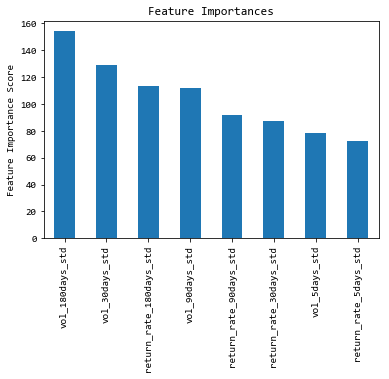

In [277]:
#Choose all predictors except target & IDcols
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=30,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train_final, predictors, target)

## max_depth 和 min_weight 参数调优

In [267]:
param_test1 = {
 'max_depth':range(3,50,5),
 'min_child_weight':range(1,100,5)
}
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=30,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
gsearch1 = GridSearchCV(estimator = xgb2, param_grid = param_test1, scoring='precision',n_jobs=8,iid=False, cv=5)
gsearch1.fit(train_final[predictors],train_final[target])
gsearch1.grid_scores_, gsearch1.best_params_,     gsearch1.best_score_

E:\06_software\Anoconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.46617, std: 0.44034, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.26626, std: 0.37435, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: 0.26299, std: 0.37533, params: {'max_depth': 3, 'min_child_weight': 11},
  mean: 0.26730, std: 0.37450, params: {'max_depth': 3, 'min_child_weight': 16},
  mean: 0.26755, std: 0.37453, params: {'max_depth': 3, 'min_child_weight': 21},
  mean: 0.26506, std: 0.37499, params: {'max_depth': 3, 'min_child_weight': 26},
  mean: 0.26776, std: 0.37416, params: {'max_depth': 3, 'min_child_weight': 31},
  mean: 0.27172, std: 0.37324, params: {'max_depth': 3, 'min_child_weight': 36},
  mean: 0.27523, std: 0.37222, params: {'max_depth': 3, 'min_child_weight': 41},
  mean: 0.52508, std: 0.38861, params: {'max_depth': 3, 'min_child_weight': 46},
  mean: 0.27977, std: 0.37120, params: {'max_depth': 3, 'min_child_weight': 51},
  mean: 0.28100, std: 0.37161, params: {'max_depth': 3, 'min_child_weight': 56},
  mean: 0.47439, std: 0.43459,

In [271]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[45,46,47]
}
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=30,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
gsearch2 = GridSearchCV(estimator = xgb2, param_grid = param_test2, scoring='precision',n_jobs=8,iid=False, cv=5)
gsearch2.fit(train_final[predictors],train_final[target])
gsearch2.grid_scores_, gsearch2.best_params_,     gsearch2.best_score_

E:\06_software\Anoconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.08634, std: 0.10951, params: {'max_depth': 2, 'min_child_weight': 45},
  mean: 0.08622, std: 0.10942, params: {'max_depth': 2, 'min_child_weight': 46},
  mean: 0.08622, std: 0.10942, params: {'max_depth': 2, 'min_child_weight': 47},
  mean: 0.47555, std: 0.43388, params: {'max_depth': 3, 'min_child_weight': 45},
  mean: 0.52508, std: 0.38861, params: {'max_depth': 3, 'min_child_weight': 46},
  mean: 0.27531, std: 0.37207, params: {'max_depth': 3, 'min_child_weight': 47},
  mean: 0.32739, std: 0.17498, params: {'max_depth': 4, 'min_child_weight': 45},
  mean: 0.29745, std: 0.21379, params: {'max_depth': 4, 'min_child_weight': 46},
  mean: 0.49851, std: 0.29452, params: {'max_depth': 4, 'min_child_weight': 47}],
 {'max_depth': 3, 'min_child_weight': 46},
 0.52507793590860685)

## gamma参数调优

In [273]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,500,5)]
}
xgb3 = XGBClassifier( 
    learning_rate =0.1, 
    n_estimators=30, max_depth=3, 
    min_child_weight=46, gamma=0, 
    subsample=0.8, colsample_bytree=0.8, 
    objective= 'binary:logistic', 
    nthread=8, 
    scale_pos_weight=1,
    seed=27)
gsearch3 = GridSearchCV(estimator=xgb3, param_grid = param_test3, scoring='precision',n_jobs=8,iid=False, cv=5)
gsearch3.fit(train_final[predictors],train_final[target])
gsearch3.grid_scores_, gsearch3.best_params_,     gsearch3.best_score_

E:\06_software\Anoconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.52508, std: 0.38861, params: {'gamma': 0.0},
  mean: 0.52508, std: 0.38861, params: {'gamma': 0.5},
  mean: 0.52508, std: 0.38861, params: {'gamma': 1.0},
  mean: 0.52508, std: 0.38861, params: {'gamma': 1.5},
  mean: 0.52629, std: 0.38762, params: {'gamma': 2.0},
  mean: 0.52629, std: 0.38762, params: {'gamma': 2.5},
  mean: 0.52629, std: 0.38762, params: {'gamma': 3.0},
  mean: 0.52629, std: 0.38762, params: {'gamma': 3.5},
  mean: 0.52629, std: 0.38762, params: {'gamma': 4.0},
  mean: 0.52910, std: 0.38538, params: {'gamma': 4.5},
  mean: 0.52916, std: 0.38533, params: {'gamma': 5.0},
  mean: 0.32916, std: 0.34661, params: {'gamma': 5.5},
  mean: 0.34524, std: 0.34470, params: {'gamma': 6.0},
  mean: 0.34784, std: 0.34390, params: {'gamma': 6.5},
  mean: 0.34784, std: 0.34390, params: {'gamma': 7.0},
  mean: 0.34784, std: 0.34390, params: {'gamma': 7.5},
  mean: 0.35078, std: 0.34257, params: {'gamma': 8.0},
  mean: 0.47948, std: 0.43141, params: {'gamma': 8.5},
  mean: 0.

    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0        0.597012      0.012475        0.609723       0.008619
1        0.625278      0.016617        0.640217       0.005724
2        0.633781      0.015535        0.652382       0.004146
3        0.641437      0.012855        0.660844       0.002437
4        0.643666      0.014788        0.664351       0.003462
5        0.646613      0.015690        0.667147       0.001496
6        0.649437      0.016063        0.670110       0.002795
7        0.652502      0.014199        0.672150       0.002119
8        0.653586      0.013683        0.673735       0.002896
9        0.655397      0.012009        0.676009       0.002533
10       0.656287      0.012353        0.676502       0.003134
11       0.657134      0.012126        0.677071       0.003487
12       0.657599      0.011784        0.678997       0.003664
13       0.659421      0.010911        0.681231       0.002774
14       0.660279      0.010819        0.681946       0

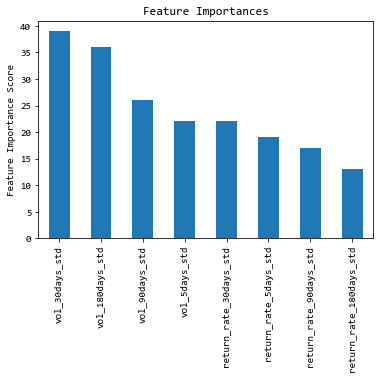

In [278]:
xgb_new = XGBClassifier(
 learning_rate =0.1,
 n_estimators=30,
 max_depth=3,
 min_child_weight=46,
 gamma=5,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
scale_pos_weight=1,
seed=27)

modelfit(xgb_new, train_final, predictors, target)

In [281]:
XGBClassifier??

In [294]:
model_lib = {'dtc': tree.DecisionTreeClassifier(min_samples_leaf=30), 'logreg': linear_model.LogisticRegression()}

In [282]:
xgb_new.fit(train_final.iloc[:, :-1], train_final.iloc[:, -1])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=46, missing=None, n_estimators=30,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [298]:
xgb_new.predict(train_final.iloc[:, :-1])

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [295]:
dtc=model_lib['dtc']
dtc.fit(train_final.iloc[:, :-1], train_final.iloc[:, -1])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [297]:
metrics.precision_score(dtc.predict(train_final.iloc[:, :-1]), train_final.iloc[:, -1])

0.44229500989228404

In [ ]:
metrics.precision_score(dtc.predict(train_final.iloc[:, :-1]), train_final.iloc[:, -1])

In [280]:
scores_roc_dtc = cross_val_score(xgb_new, train_final.iloc[:, :-1], train_final.iloc[:, -1], cv=10, scoring='precision')

E:\06_software\Anoconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\06_software\Anoconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\06_software\Anoconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\06_software\Anoconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\06_software\Anoconda\lib\site-packages\sklearn\metrics\classification.py:1135: Undefi

In [167]:
scores_roc_dtc.mean()

0.42041854327420741

In [168]:
scores_roc_dtc.std()

0.10802850495921576

In [ ]:
print(scores_roc_dtc.std(), scores_roc_log.std())

In [7]:
X_train, y_train = train_final.iloc[:,:-1].copy(), train_final.iloc[:,-1].copy()
X_test, y_test = test_final.iloc[:,:-1].copy(), test_final.iloc[:,-1].copy()

In [26]:
import time
dtc = tree.DecisionTreeClassifier()
start = time.clock()
dtc.fit(X_train, y_train)
end = time.clock()
dtc.score(X_train, y_train)
y_pred = dtc.predict(X_test)
print('决策树分类器的准确率：\n', accuracy_score(y_test, y_pred))
print('决策树分类器run time(sec):\n', (end - start))

决策树分类器的准确率：
 0.500142218797
决策树分类器run time(sec):
 19.833750538181913


In [27]:
Logreg = linear_model.LogisticRegression()
start = time.clock()
Logreg.fit(X_train, y_train)
end = time.clock() 
y_pred = Logreg.predict(X_test)
print('逻辑回归分类器的准确率：\n', accuracy_score(y_test, y_pred))
print('逻辑回归分类器run time(sec):\n', (end - start))

逻辑回归分类器的准确率：
 0.526601796545
逻辑回归分类器run time(sec):
 5.572963362726323


In [214]:
a=Logreg.predict_proba(X_test)

In [222]:
a

array([[ 0.48284796,  0.51715204],
       [ 0.49266875,  0.50733125],
       [ 0.5272896 ,  0.4727104 ],
       ..., 
       [ 0.51859692,  0.48140308],
       [ 0.49725712,  0.50274288],
       [ 0.43092345,  0.56907655]])

In [223]:
a[:,1].

0.69801936469690118

In [213]:
Logreg.classes_

array([0, 1], dtype=int64)

In [256]:
new = test_final.iloc[100,:-1]

In [257]:
array(new).reshape(-1,1)

array([[ 0.2681024 ],
       [-0.0585416 ],
       [ 1.13307905],
       [-0.68500126],
       [ 0.01255389],
       [-0.04142394],
       [-0.03341019],
       [ 0.0308386 ],
       [-0.40017573],
       [-0.05363267],
       [ 0.0355111 ],
       [-0.61993835],
       [-0.07439054],
       [-0.28385904],
       [-0.2708666 ],
       [-0.62928044],
       [-0.11814996],
       [ 0.5150603 ],
       [-0.05608296],
       [-0.52182836],
       [-0.54028823],
       [-0.70489831],
       [-0.59599194],
       [-0.41018654]])

In [258]:
Logreg.predict_proba(array(new).reshape(-1,1))

ValueError: X has 1 features per sample; expecting 24

In [8]:
import xgboost as xgb
from sklearn import cross_validation

E:\06_software\Anoconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
m_class=xgb.XGBClassifier(
 learning_rate = 0.1,
 n_estimators = 1000,
 max_depth = 5,
 gamma = 0,
 subsample = 0.8,
 colsample_bytree = 0.8,
 objective = 'binary:logistic',
 nthread = 4,
 seed = 27)

In [22]:
m_class.fit(X_train, y_train)
test_21=m_class.predict(X_test)
print("Accuracy : %.2f" % metrics.accuracy_score(y_test, test_21))

NameError: name 'metrics' is not defined

In [14]:
from sklearn import metrics

In [24]:
print("Accuracy : %.2f" % metrics.accuracy_score(y_test, test_21))

Accuracy : 0.49


In [16]:
from sklearn import svm, grid_search, datasets
from sklearn import grid_search
from xgboost import XGBClassifier

In [11]:
param_test1 = { \
'max_depth': [i for i in range(3, 10, 2)], \
'min_child_weight': [i for i in range(1, 6, 2)]}

In [17]:
gsearch1 = grid_search.GridSearchCV( \
estimator = XGBClassifier(learning_rate=0.1,
n_estimators=100, max_depth=5,
min_child_weight=1,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
objective='binary:logistic',
nthread=4,
scale_pos_weight=1,
seed=27),
param_grid = param_test1,
scoring = 'roc_auc',
n_jobs = 4,
iid = False,
cv = 5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.29471, std: 0.13490, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.29492, std: 0.13480, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.29477, std: 0.13498, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.29265, std: 0.13457, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.29440, std: 0.13695, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.29623, std: 0.13994, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.28792, std: 0.13525, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.29011, std: 0.13929, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.28914, std: 0.13788, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.28457, std: 0.13466, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.28699, std: 0.13793, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.28550, std: 0.13727, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 5

In [26]:
gsearch1.best_score_

0.2962307059142266

In [22]:
param_test3={
 'gamma': [i / 10.0 for i in range(0, 5)]
}
gsearch3 = GridSearchCV(
estimator = XGBClassifier(
learning_rate=0.1,
n_estimators=140,
max_depth=4,
min_child_weight=6,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
objective='binary:logistic',
nthread=4,
scale_pos_weight=1,
seed=27),
param_grid = param_test3,
scoring = 'roc_auc',
n_jobs = 4,
iid = False,
cv = 5)
gsearch3.fit(X_train, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

NameError: name 'train' is not defined